In [28]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set random seed for reproducibility
np.random.seed(42)

# Load the preprocessed data from Day 1
# Note: You need to run Day 1 notebook first to have these variables available
# or load them from saved files

# Build the LSTM model with multiple layers
def create_lstm_model(sequence_length, n_features):
    model = Sequential([
        # First LSTM layer with return_sequences=True to connect to the next LSTM layer
        LSTM(units=50, return_sequences=True, input_shape=(sequence_length, n_features)),
        Dropout(0.2),
        # Second LSTM layer
        LSTM(units=50),
        Dropout(0.2),
        # Output layer
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
sequence_length = 60  # Same as in Day 1
n_features = 5  # Number of features (Open, High, Low, Close, Volume)
model = create_lstm_model(sequence_length, n_features)

# Display model summary
model.summary()


/Users/ricardomatos/Documents/DEVELOPER/FIAP/FIAP-2024-MLET-Fase4/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0018 - val_loss: 0.0423
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0408
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 0.0391
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0403
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - val_loss: 0.0400
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0423
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0390
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - val_loss: 0.0400
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0414
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 0.0431
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 0.0459
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

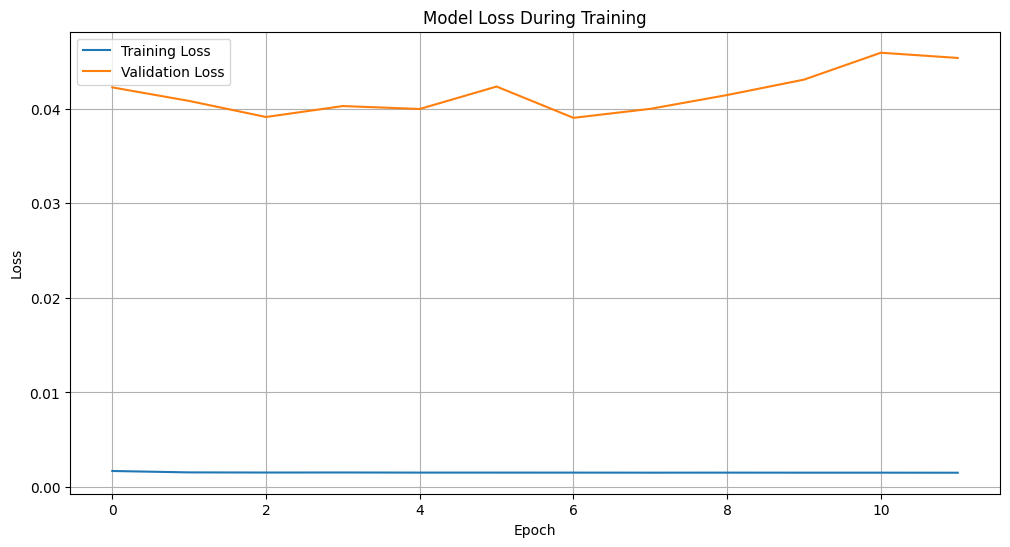

In [29]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

import os

# Load preprocessed data arrays (adjust the file paths as needed)

X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')

# Train the model
epochs = 50
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model and training history
model.save('../models/tesla_lstm_model.keras')

# Save training history to a file
history_dict = history.history
np.save('../models/training_history.npy', history_dict)

# You can load the history later with:
# history_dict = np.load('models/training_history.npy', allow_pickle=True).item()


In [32]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
# We need to reshape the data back to the original format for inverse transform
def inverse_transform_predictions(scaler, y_pred, y_test):
    # Create a dummy array with the same shape as our original data
    dummy = np.zeros((len(y_pred), 5))
    # Put our predictions in the Close price column (index 3)
    dummy[:, 3] = y_pred.flatten()
    # Inverse transform
    y_pred_transformed = scaler.inverse_transform(dummy)[:, 3]
    
    # Do the same for actual values
    dummy[:, 3] = y_test.flatten()
    y_test_transformed = scaler.inverse_transform(dummy)[:, 3]
    
    return y_pred_transformed, y_test_transformed

# Transform predictions back to original scale
y_pred_orig, y_test_orig = inverse_transform_predictions(scaler, y_pred, y_test)

# Calculate metrics
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)

print(f'Mean Absolute Error: ${mae:.2f}')
print(f'Root Mean Squared Error: ${rmse:.2f}')
print(f'Mean Absolute Percentage Error: {mape*100:.2f}%')

# Plot predictions vs actual values
plt.figure(figsize=(15, 7))
plt.plot(y_test_orig, label='Actual Prices', alpha=0.8)
plt.plot(y_pred_orig, label='Predicted Prices', alpha=0.8)
plt.title('Tesla Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediction error distribution
errors = y_test_orig - y_pred_orig
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.histplot(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (USD)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(y=errors)
plt.title('Box Plot of Prediction Errors')
plt.ylabel('Error (USD)')
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


ValueError: could not broadcast input array from shape (2300,) into shape (460,)